# Largest Rectangle under a histogram

Problem description: https://leetcode.com/problems/largest-rectangle-in-histogram/

In [61]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
tests = (
    ([2, 1, 5, 6, 2, 3], 10),
    ([6, 3, 1, 4, 12, 4], 12),
    ([5, 6, 7, 4, 1], 16),
    ([2, 1, 3, 4, 1], 6),
)

Which look like:

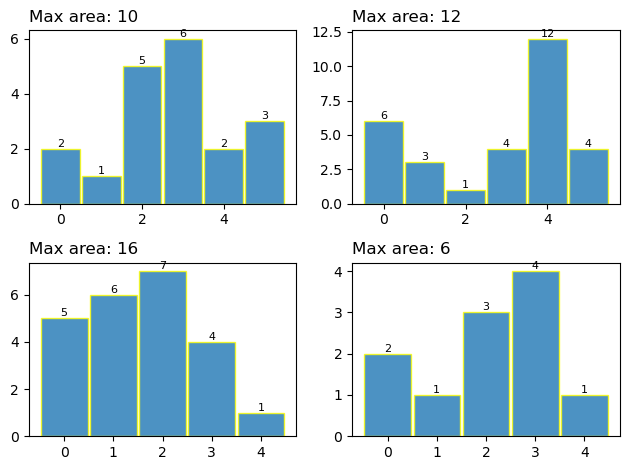

In [60]:
#| code-fold: true
#| echo: true
fig, axes = plt.subplots(2, 2, layout="tight")
for ax, (arr, ans) in zip(axes.flatten(), tests):
    bar = ax.bar(
        range(len(arr)),
        arr,
        width=0.95,
        alpha=0.8,
        edgecolor="yellow",
    )
    ax.set_title(f"Max area: {ans}", loc="left")
    ax.bar_label(bar, fontsize=8)

## A simple solution

We can brute force this by generating all possible rectangles in the histogram.

I'm doing a simple alogrithm here:

For each N in the arry:
    find the left and right boundary of the largest possible rectangle
    this gives us the width, which we multiple by N to get the area 


In [185]:
def find_boundary(idx: int, arr, debug=False) -> tuple[int, int]:
    """
    Example:
        idx 2 for [2, 1, 5, 6, 2, 3] returns (2, 3)
    Returns:
        (left, right)
    """

    # find left boundary (can be itself)
    left = 0  #
    if idx == left:
        pass  # at left edge, so left = 0
    else:
        for j in range(idx - 1, -1, -1):
            if arr[j] < arr[idx]:
                left = j + 1
                # exit the for loop once the first left boundary is found
                break

    # find right boundary (can be itself)
    right = len(arr) - 1  # default value

    if idx == right:
        pass  # at right edge already, ro right = rightmost idx
    else:
        for j in range(idx, len(arr)):
            if arr[j] < arr[idx]:
                right = j - 1
                break

    return left, right

# testing this for the first arrary in the tests
for arr, ans in tests:
    print("-----", arr, "---------")
    for i in range(len(arr)):
        print(i, arr[i], find_boundary(i, arr))
    break

----- [2, 1, 5, 6, 2, 3] ---------
0 2 (0, 0)
1 1 (0, 5)
2 5 (2, 3)
3 6 (3, 3)
4 2 (2, 5)
5 3 (5, 5)


The `find_boundary` func is working, so now its easy to get the area of the max rectangle. 

The below function iterates through every item in the array, calculates the area of the largest rectangle at that point, and updates the max area function.

In [183]:
def max_area(arr=arr):
    """returns the area of the biggest rectangle"""
    max_area = 0
    for i in range(len(arr)):
        left, right = find_boundary(i, arr)
        # adding 1 to width as when we calc (right - left) it excludes itself
        width = 1 + right - left
        max_area = max(max_area, arr[i] * width)
    
    return max_area

for arr, ans in tests:
    assert max_area(arr) == ans

## Using stacks

A work in progress...


In [184]:
def histogram_max_area(arr):
    stack = [-1]
    max_area = 0
    for i in range(len(arr)):
        while stack[-1] != -1 and arr[stack[-1]] >= arr[i]:
            current_height = arr[stack.pop()]
            current_width = i - stack[-1] - 1
            max_area = max(max_area, current_height * current_width)
        stack.append(i)

    while stack[-1] != -1:
        current_height = arr[stack.pop()]
        current_width = len(arr) - stack[-1] - 1
        max_area = max(max_area, current_height * current_width)
    return max_area


for arr, ans in tests:
    assert histogram_max_area(arr) == ans
    print(f"{arr} ----> {ans}")

print(f"all {len(tests)} tests passed!")

[2, 1, 5, 6, 2, 3] ----> 10
[6, 3, 1, 4, 12, 4] ----> 12
[5, 6, 7, 4, 1] ----> 16
[2, 1, 3, 4, 1] ----> 6
all 4 tests passed!
